# **EECS 504 PS9: Panoramic Stitching**

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

[Sara] [Shoouri], [sshoouri]

__Important__: after you download the .ipynb file, please name it as __\<your_uniquename\>_\<your_umid\>.ipynb__ before you submit it to canvas. Example: adam_01101100.ipynb.


# Brief Overview

In this problem set, you will implement panoramic stitching. Given two input images, we will "stitch" them together to create a simple panorama. To construct the image panorama, we will use concepts learned in class such as keypoint detection, local invariant descriptors, RANSAC, and perspective warping. 

The panoramic stitching algorithm consists of four main steps which we ask you to implement in individual functions:

1. Detect keypoints and extract local invariant descriptors (we will be using ORB) from two input images. 

2. Match the descriptors between the two images.

3. Apply RANSAC to estimate a homography matrix between the extracted features.

4. Apply a perspective transformation using the homography matrix to merge image into a panorama.

Functions to implement (refer to function comments for more detail):

1. get_orb_features (1 point)

2. match_keypoints (1 point)

3. find_homography and transform_ransac (1 point each)

4. panoramic_stitching (1 points)

# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [0]:
%matplotlib inline
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [0]:
%%capture
! wget -O img1.jpg "https://drive.google.com/uc?export=download&id=1omMydL6ADxq_vW5gl_1EFhdzT9kaMhUt"
! wget -O img2.jpg "https://drive.google.com/uc?export=download&id=12lxB1ArAlwGn97XgBgt-SFyjE7udMGvf"

# Visualize Input Images

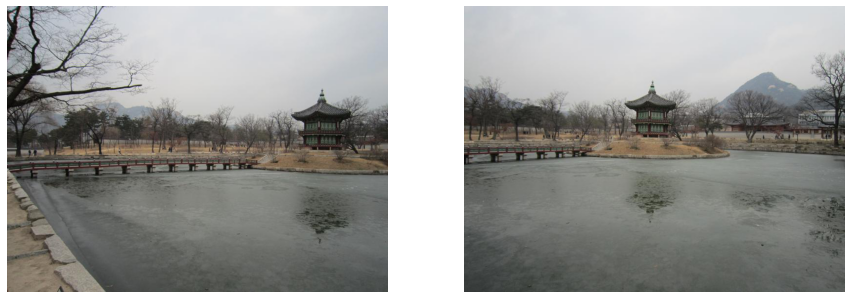

In [3]:
img1 = plt.imread('img1.jpg')
img2 = plt.imread('img2.jpg')

def plot_imgs(img1, img2):
  fig, ax = plt.subplots(1, 2, figsize=(15, 20))
  for a in ax:
    a.set_axis_off()
  ax[0].imshow(img1)
  ax[1].imshow(img2)

plot_imgs(img1, img2)

# Compute ORB Features and Match Keypoints

In [0]:
def get_orb_features(img):
  '''
    Compute ORB features using cv2 library functions. Use default parameters when computing the keypoints.
    Input: 
      img: cv2 image
    Returns:
      keypoints: a list of cv2 keypoints
      descriptors: a list of ORB descriptors
  '''
  # ===============================================
  # TODO
  orb = cv2.ORB_create()
  keypoints, descriptors = orb.detectAndCompute(img,None)
  # ===============================================
  return keypoints, descriptors

def match_keypoints(desc_1, desc_2, ratio=0.7):
  '''
    Compute matches between feature descriptors of two images using Lowe's ratio test. 
    You may use cv2 library functions.
    Input:
      desc_1, desc_2: list of feature descriptors
    Return:
      matches: list of feature matches
  '''
  # ===============================================
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
  matches = bf.knnMatch(desc_1,desc_2, k=2)
  good = []
  for m,n in matches:
    if m.distance < ratio*n.distance:
        good.append(m)   
  # ===============================================
  return good

keypoints for img1 and img2


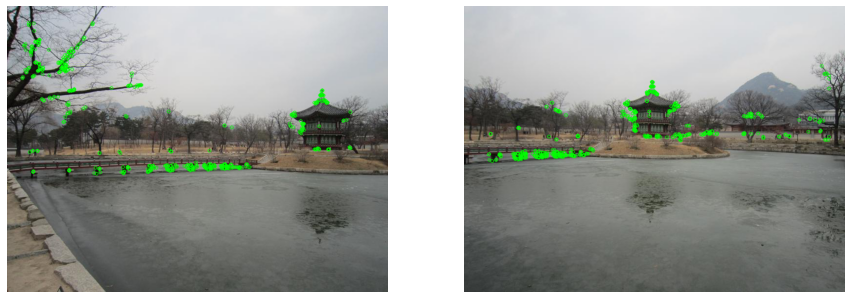

In [5]:
kp_1, desc_1 = get_orb_features(img1)
kp_2, desc_2 = get_orb_features(img2)

kp_img1 = cv2.drawKeypoints(img1, kp_1, None, color=(0,255,0), flags=0)
kp_img2 = cv2.drawKeypoints(img2, kp_2, None, color=(0,255,0), flags=0)

print('keypoints for img1 and img2')
plot_imgs(kp_img1, kp_img2)

orb feature matches


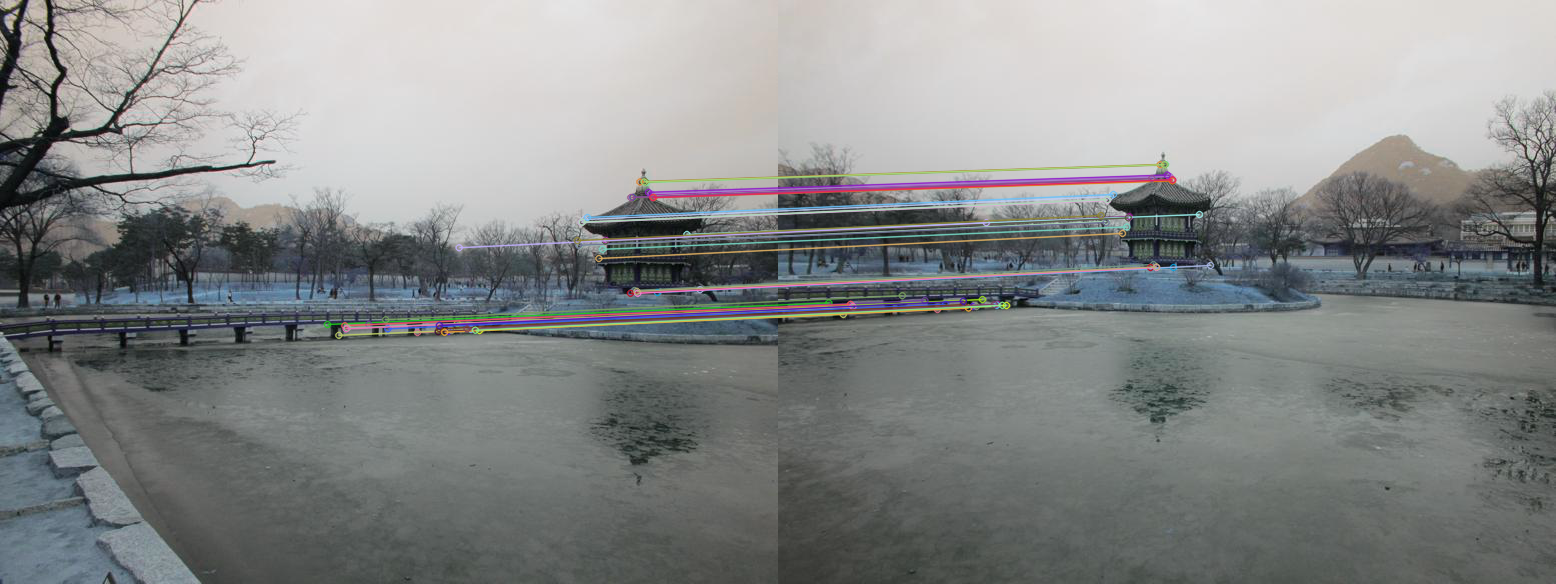

In [6]:
matches = match_keypoints(desc_1, desc_2)
match_plot = cv2.drawMatches(img1, kp_1, img2, kp_2, matches,None, flags=2)
print("orb feature matches")
cv2_imshow(match_plot)

# Compute Homography Matrix using RANSAC

In [0]:
def find_homography(pts_1, pts_2):
  '''
    Use either nonlinear least squares or direct linear transform 
    to find a homography that estimates the transformation mapping from pts_1 to pts_2.
    e.g. If x is in pts_1 and y is in pts_2, then y = H * x
    Hint: The objective function to optimize here is: ||pts_1 - cart(H*homog(pts_2))||^2 
    where homog(x) converts x into homogeneous coordinates and cart(x) converts x to cartesian coordinates.
    Input:
      pts_1, pts_1: (N, 2) matrix 
    Return:
      H: the resultant homography matrix (3 x 3)
  '''
  # ===============================================
  M=np.concatenate((pts_1,pts_2),axis=1);
  p=[]
  for corr in M:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]  
        p.append(a1)
        p.append(a2)
  matrixA = np.matrix(p)
  u, s, v = np.linalg.svd(matrixA)
  H = np.reshape(v[8], (3, 3)) #min singlur value and its right vector
  H = (1/H.item(8)) * H
  # ===============================================
  return H

In [0]:
def transform_ransac(pts_1, pts_2):
  '''
    Implements RANSAC to estimate homography matrix.
    Input:
      pts_1, pts_1: (N, 2) matrices
    Return:
      best_model: homography matrix with most inliers
  '''
  # ===============================================
  maxInliers = []
  M=np.concatenate((pts_1,pts_2),axis=1);
  best_model=[];
  N=len(pts_1);
  for i in range(10000):
    ran1 = M[random.randrange(0, len(M))]
    ran2 = M[random.randrange(0, len(M))]
    randomFour1 = np.vstack((ran1[0][:], ran2[0][:]))
    randomFour2 = np.vstack((ran1[1][:], ran2[1][:]))
    ran3 = M[random.randrange(0, len(M))]
    randomFour1= np.vstack((randomFour1, ran3[0][:]))
    randomFour2=np.vstack((randomFour2, ran3[1][:]))
    ran4 = M[random.randrange(0, len(M))]
    randomFour1= np.vstack((randomFour1, ran4[0][:]))
    randomFour2=np.vstack((randomFour2, ran4[1][:]))
    h =find_homography(randomFour1,randomFour2)
    inliers = []

    for i in range(len(M)):
      p1 = np.transpose(np.matrix([M[i][0].item(0), M[i][0].item(1), 1]))
      estimatep2 = np.dot(h, p1)
      estimatep2 = (1/estimatep2.item(2))*estimatep2
      p2 = np.transpose(np.matrix([M[i][1].item(0), M[i][1].item(1), 1]))
      error = p2 - estimatep2
      d=np.linalg.norm(error)
      if d < 5:
            inliers.append(M[i])

    if len(inliers) > len(maxInliers):
        maxInliers = inliers
        best_model = h

    if len(maxInliers) > (len(M)*0.6):
        break

    
    
    
  return best_model

# Panoramic Stitching

In [0]:
def panoramic_stitching(img1, img2):
  '''
    Given a pair of overlapping images, generate a panoramic image. 
 $   Hint: use the functions that you've written in the previous parts.
    Hint: you may use OpenCV function to apply perspective wrapping.
    Input: 
      img1, img2: cv2 images
    Return:
      final_img: cv2 image of panorama
  '''
  # ===============================================
  kp1, desc_1 = get_orb_features(img2)
  kp2, desc_2 = get_orb_features(img1)
  good = match_keypoints(desc_1, desc_2)
  src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
  dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
  H=transform_ransac(src_pts, dst_pts)
  
  width = img1.shape[1]+img2.shape[1]
  height = img2.shape[0] 
  warpedImage = cv2.warpPerspective(img2, H, (width, height))
  warpedImage[0:img1.shape[0], 0:img1.shape[1]] = img1


  # ===============================================
  return warpedImage

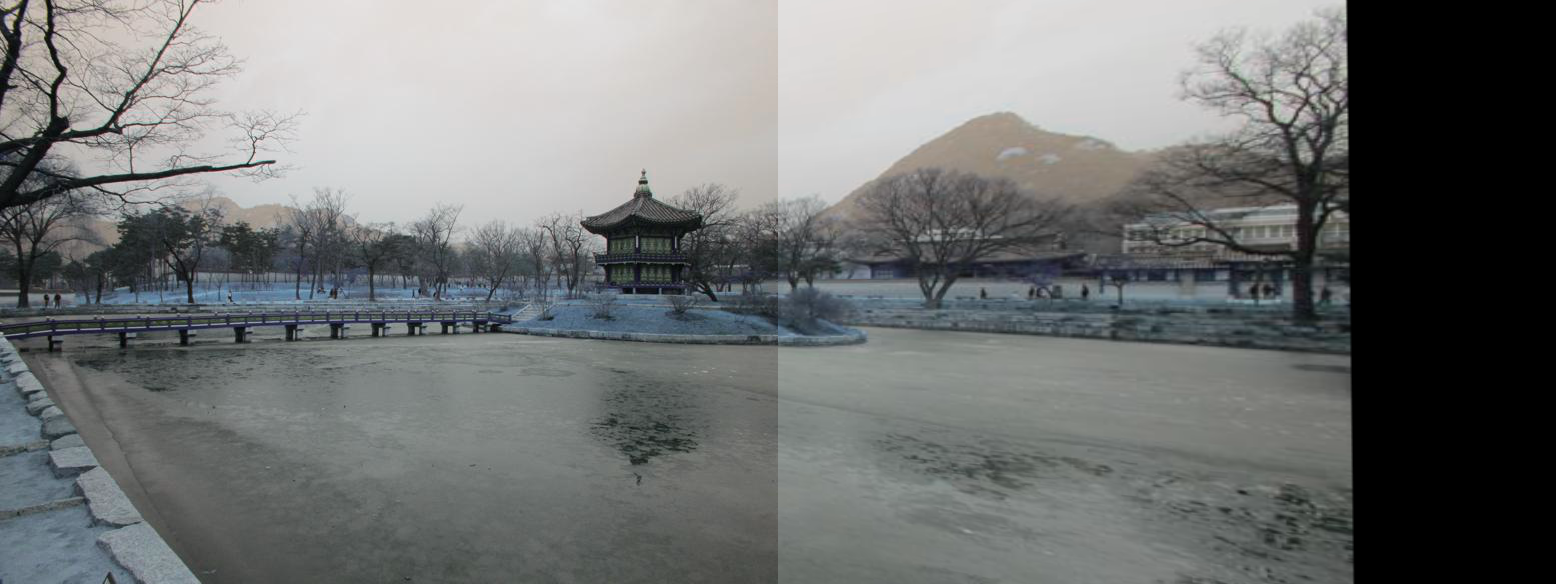

In [165]:
result = panoramic_stitching(img1, img2)
cv2_imshow(result)
